<a href="https://colab.research.google.com/github/glitch401/multi-output-assignment/blob/main/distillbert-multi-label-output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir data
!unzip -q /content/drive/MyDrive/task_data.zip -d ./data

In [3]:
import pandas as pd

trainDf = pd.read_csv('/content/data/task_data/train_data.csv')
validDf = pd.read_csv('/content/data/task_data/valid_data.csv')

trainDf.sample(5)

,path,transcription,action,object,location
11124,wavs/speakers/73bEEYMKLwtmVwV43/4ccc9980-452e-...,Turn down the heat in the washroom,decrease,heat,washroom
1946,wavs/speakers/anvKyBjB5OiP5dYZ/96d97810-4577-1...,Turn the temperature down in the washroom,decrease,heat,washroom
981,wavs/speakers/oXjpaOq4wVUezb3x/250fbde0-4511-1...,Increase the sound,increase,volume,none
9559,wavs/speakers/8e5qRjN7dGuovkRY/24d6e410-4594-1...,Turn up the heat,increase,heat,none
4768,wavs/speakers/mor8vDGkaOHzLLWBp/58fa72f0-4541-...,Turn the heat up in the washroom,increase,heat,washroom


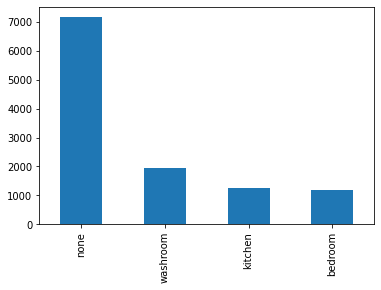

In [4]:
trainDf['location'].value_counts().plot.bar()

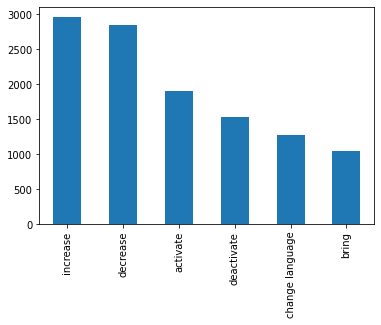

In [5]:
trainDf['action'].value_counts().plot.bar()

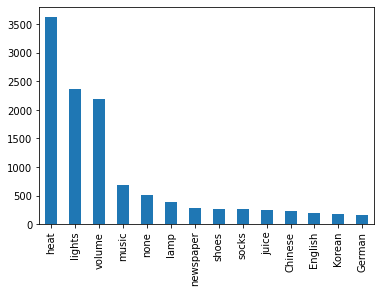

In [6]:
trainDf['object'].value_counts().plot.bar()

In [7]:
!pip install transformers -q

     |████████████████████████████████| 3.4 MB 26.8 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 895 kB 57.3 MB/s 
     |████████████████████████████████| 596 kB 71.2 MB/s 
     |████████████████████████████████| 3.3 MB 58.0 MB/s 


In [8]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, DistilBertModel, DistilBertTokenizer
from torch import nn as nn
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
  def __init__(self, df, tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')):
    df = df.dropna(axis=0, subset=['transcription'])
    self.label_cols = ['action', 'object', 'location']
    self.label_encoders = []
    
    for col in self.label_cols:
      le = LabelEncoder()
      df[col] = le.fit_transform(df[col])
      self.label_encoders.append(le)

    self.texts = df['transcription'].tolist()
    self.action = df['action'].tolist()
    self.object = df['object'].tolist()
    self.location = df['location'].tolist()

    self.tokenizer = tokenizer

  def __getitem__(self, index):
      encoded = self.tokenizer.encode_plus(self.texts[index], max_length=60, padding='max_length')
      return {
          'input_ids': torch.tensor(encoded['input_ids'], dtype=torch.long),
          'attention_mask': torch.tensor(encoded['attention_mask'], dtype=torch.long),
          # 'token_type_ids': torch.tensor(encoded['token_type_ids'], dtype=torch.long),
          'action': torch.tensor(self.action[index], dtype=torch.long),
          'object': torch.tensor(self.object[index], dtype=torch.long), 
          'location': torch.tensor(self.location[index], dtype=torch.long)}
      # return encoded['input_ids'], encoded['attention_mask'], self.action[index], self.object[index], self.location[index]

      
  def __len__(self):
    return len(self.location)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_batch_size = 32
trainSet = TextDataset(trainDf)
trainLoader = DataLoader(trainSet, batch_size=train_batch_size, shuffle=True, pin_memory=device)

valSet = TextDataset(validDf)
valLoader = DataLoader(valSet, batch_size=8, shuffle=True, pin_memory=device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
from transformers import logging
logging.set_verbosity_error()

class MultiLabelTextClassifier(nn.Module):
  def __init__(self, no_class1,no_class2,no_class3):
    super(MultiLabelTextClassifier, self).__init__()
    self.distil = DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(768, 256)
    self.out1 = nn.Linear(256, no_class1)
    self.out2 = nn.Linear(256, no_class2)
    self.out3 = nn.Linear(256, no_class3)

    self.no_classes = (no_class1,no_class2,no_class3)


  def forward(self, input_ids, attention_mask):
    out = self.distil(input_ids = input_ids, 
                   attention_mask =attention_mask,
                  #  token_type_ids = data['token_type_ids'], 
                   return_dict=False)[0][:, 0]
    out = self.drop(out)
    out = self.fc(out)
    out1 = self.out1(out)
    out2 = self.out2(out)
    out3 = self.out3(out)

    return {'action': out1, 'object': out2, 'location': out3}


model = MultiLabelTextClassifier(len(trainDf['action'].unique()),
                                 len(trainDf['object'].unique()),
                                 len(trainDf['location'].unique()),).to(device)
# model(next(iter(trainLoader))) # for sanifty check of first pass

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup 
from tqdm import tqdm

for parms in model.distil.parameters():
    parms.requires_grad = False

history = {
    'train':[],
    'valid':[]
}
epoch_history = {
    'train':[],
    'valid':[]
}

def train_model(model, epochs):
  optim = AdamW(model.parameters(), lr=3e-5)
  scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=0,
                                              num_training_steps=len(trainSet)/train_batch_size*epochs)
  criterions = [nn.CrossEntropyLoss() for i in range(3)]
  criterion1 = nn.CrossEntropyLoss()
  best_val_loss = 9999999999
  
  for epoch in range(1, epochs+1):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    trainLoop = tqdm(enumerate(trainLoader), 
                               total=len(trainLoader),
                               leave=False)
    
    for i, data in trainLoop:
      optim.zero_grad()
      labels= [data['action'].to(device), data['object'].to(device), data['location'].to(device)]
      output = model(data['input_ids'].to(device), data['attention_mask'].to(device))
      labels_h = [output['action'], output['object'], output['location']]
      # print(labels[0].shape, labels_h[0].shape)
      # loss1 = criterions[0](labels_h[0], labels[0].squeeze())
      losses = sum([criterions[i](labels_h[i], labels[i].squeeze()) for i in range(3)])
      losses.backward()
      optim.step()
      scheduler.step()

      losss = ((1/(i+1)) * (losses.data-train_loss))
      train_loss +=losss
      history['train'].append(losss.item())
      trainLoop.set_postfix(loss=losss.item())

    model.eval()
    valLoop = tqdm(enumerate(valLoader), total=len(valLoader), leave=False)
    for i, data in valLoop:
      labels= [data['action'].to(device), data['object'].to(device), data['location'].to(device)]
      output = model(data['input_ids'].to(device), data['attention_mask'].to(device))
      labels_h = [output['action'], output['object'], output['location']]
      losses = sum([criterions[i](labels_h[i], labels[i].squeeze()) for i in range(3)])
      losss = ((1/(i+1)) * (losses.data-val_loss))
      val_loss +=losss
      history['valid'].append(losss.item())
      valLoop.set_postfix(loss=losss.item())
    
    
    epoch_history['train'].append(train_loss)   
    epoch_history['valid'].append(val_loss)   
    if abs(val_loss) < abs(best_val_loss):
            torch.save(model, 'model.pt')

  return model


trained_model = train_model(model, epochs=5)

In [18]:
epoch_history

{'train': [tensor(2.8211, device='cuda:0'),
  tensor(2.3745, device='cuda:0'),
  tensor(2.1171, device='cuda:0'),
  tensor(1.9740, device='cuda:0'),
  tensor(1.8998, device='cuda:0')],
 'valid': [tensor(2.3964, device='cuda:0'),
  tensor(2.0612, device='cuda:0'),
  tensor(1.8668, device='cuda:0'),
  tensor(1.7650, device='cuda:0'),
  tensor(1.7313, device='cuda:0')]}

In [19]:
trained_model = train_model(trained_model, epochs=15)
epoch_history

{'train': [tensor(2.8211, device='cuda:0'),
  tensor(2.3745, device='cuda:0'),
  tensor(2.1171, device='cuda:0'),
  tensor(1.9740, device='cuda:0'),
  tensor(1.8998, device='cuda:0'),
  tensor(1.7413, device='cuda:0'),
  tensor(1.5017, device='cuda:0'),
  tensor(1.3300, device='cuda:0'),
  tensor(1.1984, device='cuda:0'),
  tensor(1.0927, device='cuda:0'),
  tensor(1.0123, device='cuda:0'),
  tensor(0.9505, device='cuda:0'),
  tensor(0.8965, device='cuda:0'),
  tensor(0.8496, device='cuda:0'),
  tensor(0.8156, device='cuda:0'),
  tensor(0.7861, device='cuda:0'),
  tensor(0.7663, device='cuda:0'),
  tensor(0.7497, device='cuda:0'),
  tensor(0.7435, device='cuda:0'),
  tensor(0.7399, device='cuda:0')],
 'valid': [tensor(2.3964, device='cuda:0'),
  tensor(2.0612, device='cuda:0'),
  tensor(1.8668, device='cuda:0'),
  tensor(1.7650, device='cuda:0'),
  tensor(1.7313, device='cuda:0'),
  tensor(1.4528, device='cuda:0'),
  tensor(1.2540, device='cuda:0'),
  tensor(1.1058, device='cuda:0'),
 

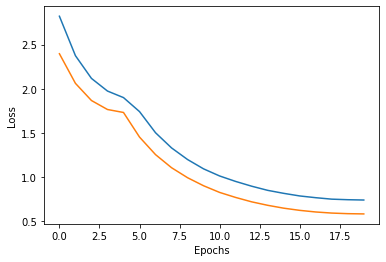

In [21]:
import matplotlib.pyplot as plt

plt.plot(epoch_history['train'])
plt.plot(epoch_history['valid'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [53]:
def infer(model, text, device = torch.device('cpu'),
          tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')):
  model = model.to(device)
  model.eval()
  # if not isinstance(texts, list):
  #   texts = [texts]

  print(text)
  encoded = tokenizer.encode_plus(text)
  out = model(torch.tensor(encoded['input_ids'], dtype=torch.long).to(device).view(1,-1), 
              torch.tensor(encoded['attention_mask'], dtype=torch.long).to(device).view(1,-1))
  
  return (valSet.label_encoders[0].inverse_transform([torch.argmax(out['action'])])[0], 
        valSet.label_encoders[1].inverse_transform([torch.argmax(out['object'])])[0], 
        valSet.label_encoders[2].inverse_transform([torch.argmax(out['location'])])[0])

infer(trained_model, 'Switch on the lights in the bedroom')

Switch on the lights in the bedroom


('activate', 'lights', 'bedroom')